## Proximal Policy Optimization (PPO) ##

Основные характеристики:

- Model-free
- Actor-Critic(Актор - реализует политику, т.е выбирает действие. Критик - оценивает действия)
- On-policy


<img src="images/sensors-20-01359-g003.png" alt="image" width="70%" height="auto">

Чтобы избежать резких изменений стратегии вводится:

$r(\theta) = \frac{\pi_{\theta} (a | s)}{\pi_{\theta_{old}} (a | s)}$

это показывает насколько изменилась вероятность выбора конкретного действия после обновления параметров. Если $r(\theta)$ сильно отклоняется от 1, значит, новая политика слишком отличается от старой, и это может быть опасно для стабильности обучения

$\hat{A}$ - оценка преимущества действия

$L^{CLIP} = \mathbb{E}[\min(r_t(\theta) A_t, clip(r_t(\theta) A_t, 1 - \epsilon, 1 + \epsilon))]$, где

$\quad \epsilon$ - гиперпараметр для "обрезки"(обычно 0.1-0.3)

Итоговый loss:

$L^{PPO}(\theta) = L^{CLIP}(\theta) + c_1 L^{VF}(\theta) - c_2 S[\pi_{\theta}](s_t)$

- $L^{VF}(\theta)$ - loss для критика(value function)
- $S[\pi_{\theta}](s_t)$ - энтропия, отвечает за exploraion

__Note__:

- В SB3 используется оптимизатор `ADAM`, вместо `SGD`
- В SB3 используется **Generalized Advantage Estimation (GAE)**:

$
A_t^{GAE} = \sum_{k=0}^{T-t} (\gamma \lambda)^k \delta_{t+k}
$
где:
- $ \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t) $.  
- $ \gamma $ — дисконт-фактор.  
- $ \lambda $ — параметр сглаживания (по умолчанию `0.95`).  

### Преимущества: ###

- Стабильность, за счёт механизма __Clipped Objective__
- Работает как с дискретными, так и непрерывными действиями
- Достаточно прост

### Недостатки: ###

- Сложность обучения. Для сложных окружений может потребоваться много эпизодов
- Чувствителен к подбору параметров

__Note__:

Хотя он и работает с непрерывными средами, всё же лучше использовать другие методы, например `SAC`


In [1]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, CallbackList, BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# 1. Создание среды и оберток
env = gym.make("CartPole-v1") # 
env = Monitor(env, "./logs/")  # Логирование статистики
env = DummyVecEnv([lambda: env])  # Векторизация для ускорения


In [3]:
# 2. Гиперпараметры PPO
config = {
    "policy": "MlpPolicy",
    "learning_rate": 3e-4,
    "n_steps": 2048,          # Число шагов перед обновлением
    "batch_size": 64,         # Размер батча для обучения
    "n_epochs": 10,           # Число эпох на один набор данных
    "gamma": 0.99,            # Коэффициент дисконтирования
    "gae_lambda": 0.95,       # Параметр для GAE
    "ent_coef": 0.01,         # Коэффициент энтропии
    "verbose": 0              # Вывод логов
}

In [4]:
# 3. Инициализация модели PPO
model = PPO(
    policy=config["policy"],
    env=env,
    learning_rate=config["learning_rate"],
    n_steps=config["n_steps"],
    batch_size=config["batch_size"],
    n_epochs=config["n_epochs"],
    gamma=config["gamma"],
    gae_lambda=config["gae_lambda"],
    ent_coef=config["ent_coef"],
    verbose=config["verbose"]
)

In [ ]:
class TrainingLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.value_losses = []
        self.policy_losses = []
        self.timesteps = []
        self.loss_check_freq = 1000  # Частота записи потерь
        
    def _on_step(self) -> bool:
        if len(self.model.ep_info_buffer) > 0:
            for ep_info in self.model.ep_info_buffer:
                self.episode_rewards.append(ep_info['r'])
            self.model.ep_info_buffer.clear()
        
        if self.n_calls % self.loss_check_freq == 0:
            if hasattr(self.model, 'logger'):
                if 'train/value_loss' in self.model.logger.name_to_value:
                    self.value_losses.append(self.model.logger.name_to_value['train/value_loss'])
                if 'train/policy_loss' in self.model.logger.name_to_value:
                    self.policy_losses.append(self.model.logger.name_to_value['train/policy_loss'])
            self.timesteps.append(self.num_timesteps)
            
        return True
    
    def plot_results(self):
        plt.figure(figsize=(12, 5))
        
        # График наград
        plt.subplot(1, 2, 1)
        plt.plot( 
                self.episode_rewards, 'b-', label='Reward')
        plt.xlabel('Timesteps')
        plt.ylabel('Episode Reward')
        plt.title('Training Rewards')
        plt.grid(True)
        
        # График потерь
        plt.subplot(1, 2, 2)
        if len(self.value_losses) > 0:
            plt.plot(
                    self.value_losses, 'r-', label='Value Loss')
        if len(self.policy_losses) > 0:
            plt.plot(
                    self.policy_losses, 'g-', label='Policy Loss')
        plt.xlabel('Timesteps')
        plt.ylabel('Loss')
        plt.title('Training Losses')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

Output()

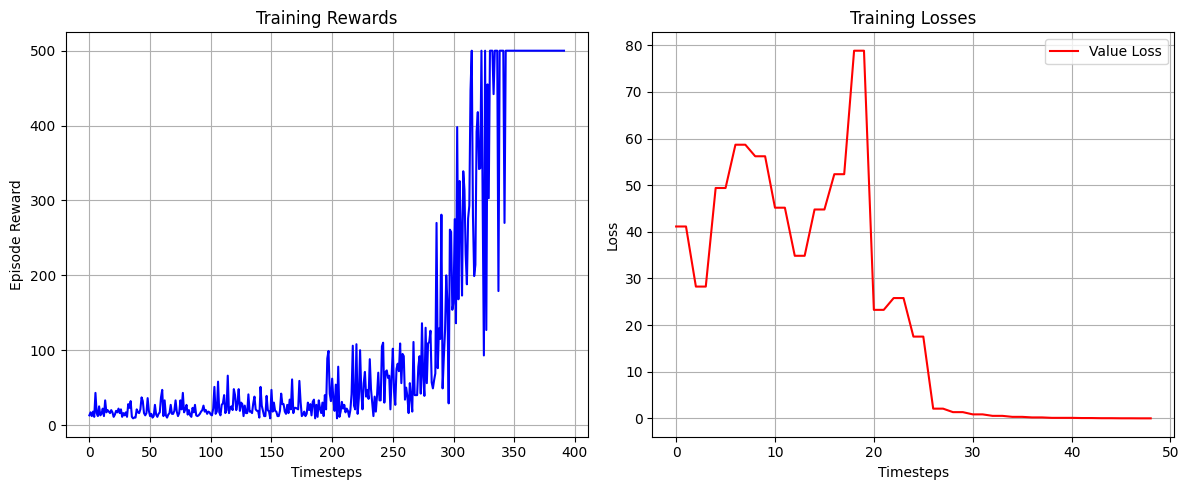

In [7]:
reward_logger = TrainingLoggerCallback()
total_timesteps = 50_000
model.learn(total_timesteps=total_timesteps,
            callback=reward_logger,
            progress_bar=True)

# 7. Визуализация результатов
reward_logger.plot_results()

In [7]:
# 6. Сохранение модели
model.save("./ppo_cartpole")
print("Модель сохранена в ppo_cartpole.zip")

Модель сохранена в ppo_cartpole.zip


In [ ]:
from stable_baselines3.common.vec_env import VecVideoRecorder


env = gym.make("CartPole-v1", render_mode="rgb_array")
env = Monitor(env, "./logs/")
env = DummyVecEnv([lambda: env])


model = PPO.load("ppo_cartpole.zip")

video_length = 1000  # Длина видео в шагах
video_folder = "./videos/"
video_name = "ppo_cartpole_video"


env = VecVideoRecorder(
    env,
    video_folder,
    record_video_trigger=lambda x: x == 0,
    video_length=video_length,
    name_prefix=video_name
)

# 5. Запуск агента и запись
obs = env.reset()
for _ in range(video_length):
    action, _ = model.predict(obs, deterministic=True)
    obs, _, _, _ = env.step(action)

env.close() 

Saving video to c:\Users\Очир\Desktop\Учёба\Машинное обучение\PPO\videos\ppo_cartpole_video-step-0-to-step-1000.mp4
MoviePy - Building video c:\Users\Очир\Desktop\Учёба\Машинное обучение\PPO\videos\ppo_cartpole_video-step-0-to-step-1000.mp4.
MoviePy - Writing video c:\Users\Очир\Desktop\Учёба\Машинное обучение\PPO\videos\ppo_cartpole_video-step-0-to-step-1000.mp4



MoviePy - Done !
MoviePy - video ready c:\Users\Очир\Desktop\Учёба\Машинное обучение\PPO\videos\ppo_cartpole_video-step-0-to-step-1000.mp4
